# <span style='background:Yellow'> Bottom Temp & Salt difference between SODA and WOA

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import geopandas
import scipy
import xesmf as xe

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
woa_path = '/home/jovyan/WMT-project/WOA/'
soda_path = '/home/jovyan/WMT-project/SODA/'
woa8110_pt = xr.open_dataset(woa_path+'pt_bottom_wg_8110.nc')
woa8110_pt_error = xr.open_dataset(woa_path+'pt_bottom_error.nc')
woa8110_slt = xr.open_dataset(woa_path+'san_bottom_wg_8110.nc')
woa8110_slt_error = xr.open_dataset(woa_path+'san_bottom_error.nc')

woa0517_pt = xr.open_dataset(woa_path+'pt_bottom_wg_0517.nc')
woa0517_pt_error = xr.open_dataset(woa_path+'pt_bottom_0517_error.nc')
woa0517_slt = xr.open_dataset(woa_path+'/san_bottom_wg_0517.nc')
woa0517_slt_error = xr.open_dataset(woa_path+'san_bottom_wg_0517_error.nc')

soda_temp = xr.open_dataset(soda_path+'bottom_temp.nc')
soda_std_temp = xr.open_dataset(soda_path+'bottom_temp_std.nc')
soda_slt = xr.open_dataset(soda_path+'bottom_salt.nc')
soda_std_slt = xr.open_dataset(soda_path+'bottom_salt_std.nc')

import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcsfs_w_token = gcsfs.GCSFileSystem(token=token)

land_mask = xr.open_zarr(gcsfs_w_token.get_mapper('pangeo-tmp/stb2145/SODA/datasets/hfacc.zarr'))
depth_wg_interp = xr.open_dataarray('depth_wg_interp.nc')

In [5]:
swap = land_mask.swap_dims({'xt_ocean':'lon', 'yt_ocean':'lat'})
land_mask = swap.assign_coords({"lon": swap.xt_ocean, 'lat':swap.yt_ocean}).drop(['xt_ocean', 'yt_ocean'])

In [6]:
d = depth_wg_interp.swap_dims({'xt_ocean':'lon', 'yt_ocean':'lat'})
depth = d.assign_coords({"lon": d.xt_ocean.values, 'lat':d.yt_ocean}).drop(['grid_y_T', 'grid_x_T', 'st_ocean',
                                                                            'yt_ocean', 'xt_ocean'])

# <span style='background:Pink'> <font color='Red'> Temperature </font>

In [ ]:
soda_temp

<xarray.Dataset>
Dimensions:  (lon: 381, lat: 169)
Coordinates:
    time     object ...
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14
Data variables:
    temp     (lat, lon) float32 ...

In [11]:
woa8110_pt.PT[0]

<xarray.DataArray 'PT' (lat: 19, lon: 96)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-0.213153, -0.37806 , -0.331057, ..., -0.905584, -0.891283, -0.878782],
       [ 0.160874, -0.032845, -0.15345 , ..., -0.762277, -0.747777, -0.736376],
       [ 0.661696,  0.478878,  0.311691, ..., -0.571269, -0.561768, -0.552068]])
Coordinates:
    time     datetime64[ns] 2000-01-15
    lev      (lat, lon) float64 ...
  * lat      (lat) float64 -79.5 -78.5 -77.5 -76.5 ... -64.5 -63.5 -62.5 -61.5
  * lon      (lon) float64 -64.5 -63.5 -62.5 -61.5 -60.5 ... 27.5 28.5 29.5 30.5

### <span style='color:Brown'> Interpolating WOA (1981-2010) temp data onto SODA's grid

In [7]:
regridder = xe.Regridder(woa8110_pt.PT[0], soda_temp.temp, method='bilinear')

woa8110_pt_new_grid = regridder(woa8110_pt)
woa8110_pt_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, lat: 169, lon: 381)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14
Data variables:
    PT       (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... -0.6817 -0.6788 -0.676
Attributes:
    regrid_method:  bilinear

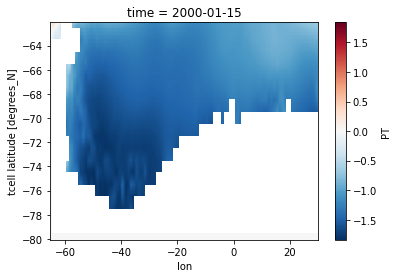

In [13]:
woa8110_pt_new_grid.PT[0].plot()

### <span style='color:Brown'> Interpolating WOA (1981-2010) temp error data onto SODA's grid

In [8]:
regridder_8110_error = xe.Regridder(woa8110_pt_error, soda_temp, method='bilinear')

woa8110_pt_error_new_grid = regridder(woa8110_pt_error)
woa8110_pt_error_new_grid

<xarray.Dataset>
Dimensions:   (time: 1, lat: 169, lon: 381)
Coordinates:
  * time      (time) object -001-01-15 00:00:00
  * lon       (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat       (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14
Data variables:
    PT_error  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.3469 0.3294 0.3172
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom temperature `SODA - WOA` (1981-2010) </font>

In [15]:
#checking if nans
print(np.isnan(soda_temp.temp.sum()))

<xarray.DataArray 'temp' ()>
array(False)
Coordinates:
    time     object 1993-01-04 13:00:00


In [9]:
soda_woa8110_diff = soda_temp.temp - woa8110_pt_new_grid.isel(time=0).PT
soda_woa8110_diff

<xarray.DataArray (lat: 169, lon: 381)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.38527429, 0.38618386, 0.38927206, ..., 0.17326919, 0.17096396,
        0.16919035],
       [0.3911812 , 0.39393991, 0.46547386, ..., 0.15073519, 0.14834517,
        0.14622904],
       [0.39906168, 0.4294568 , 0.44761479, ..., 0.12806972, 0.12522346,
        0.12225443]])
Coordinates:
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14

In [17]:
land_mask.hfacc[0]

<xarray.DataArray 'hfacc' (lat: 169, lon: 381)>
dask.array<getitem, shape=(169, 381), dtype=float64, chunksize=(22, 48), chunktype=numpy.ndarray>
Coordinates:
    time     object 1993-01-04 13:00:00
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14

In [18]:
soda_woa8110_diff.nbytes/1e9

0.000515112

In [19]:
woa8110_pt_error_new_grid.PT_error[0].nbytes/1e9

0.000515112

In [ ]:
soda_woa8110_diff.where(land_mask.hfacc[0]).plot()

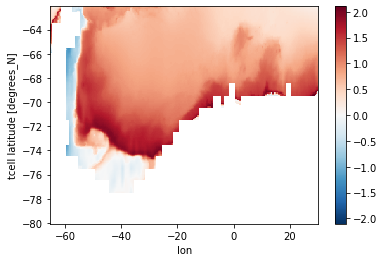

In [22]:
soda_woa8110_diff.plot()

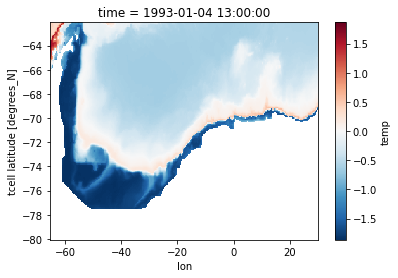

In [23]:
soda_temp.temp.plot()

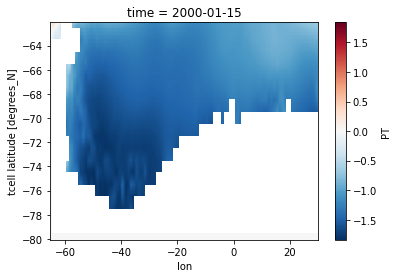

In [24]:
woa8110_pt_new_grid.isel(time=0).PT.plot()

In [17]:
soda_woa8110_diff

<xarray.DataArray (lat: 169, lon: 381)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.38527429, 0.38618386, 0.38927206, ..., 0.17326919, 0.17096396,
        0.16919035],
       [0.3911812 , 0.39393991, 0.46547386, ..., 0.15073519, 0.14834517,
        0.14622904],
       [0.39906168, 0.4294568 , 0.44761479, ..., 0.12806972, 0.12522346,
        0.12225443]])
Coordinates:
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14

In [10]:
lat = soda_woa8110_diff.lat
lon = soda_woa8110_diff.lon

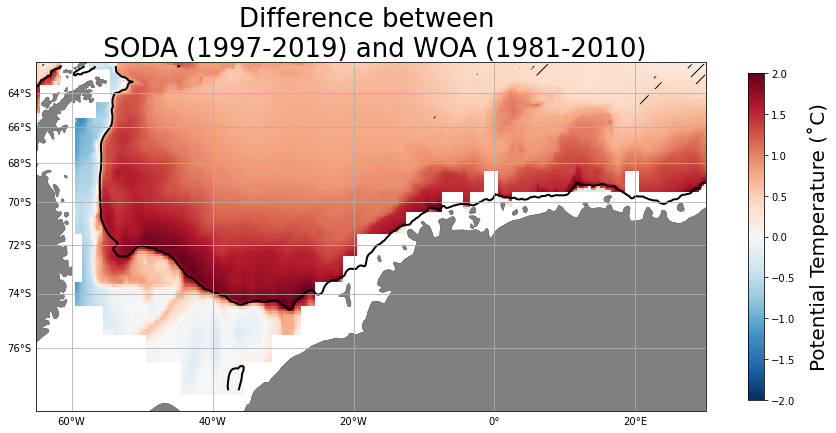

In [12]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
#ax.add_feature(cfeature.LAND, facecolor='0.8', edgecolor='k')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
#1000m isobath
ax.contour(lon, lat, depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(soda_woa8110_diff.lon, 
                   soda_woa8110_diff.lat, 
                   soda_woa8110_diff.where(land_mask.hfacc[0]), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-2, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature (˚C)", labelpad=12, fontsize=20)

plt.contourf(soda_woa8110_diff.lon, 
             soda_woa8110_diff.lat,  
             soda_woa8110_diff.where(np.abs(soda_woa8110_diff) < woa8110_pt_error_new_grid.PT_error[0]).where(land_mask.hfacc[0]),
             transform=ccrs.PlateCarree(), colors='none', hatches=['//'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n SODA (1997-2019) and WOA (1981-2010)", fontsize=26)
plt.savefig('bot-temp-sodaWoa8110-1kmisobath.pdf');

### <span style='color:Brown'> Interpolating WOA (2005-2017) temp data onto ECCO's grid

In [28]:
regridder_0517 = xe.Regridder(woa0517_pt, soda_temp, method='bilinear')

woa0517_pt_new_grid = regridder_0517(woa0517_pt)
woa0517_pt_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, lat: 169, lon: 381)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14
Data variables:
    PT       (time, lat, lon) float64 0.0 0.0 0.0 ... -0.7896 -0.7853 -0.7804
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (2005-2017) temp ERROR data onto ECCO's grid

In [30]:
regridder_0517_error = xe.Regridder(woa0517_pt_error, soda_temp, method='bilinear')

woa0517_pt_error_new_grid = regridder_0517_error(woa0517_pt_error)
woa0517_pt_error_new_grid

<xarray.Dataset>
Dimensions:   (time: 1, lat: 169, lon: 381)
Coordinates:
  * time      (time) object -001-01-15 00:00:00
  * lon       (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat       (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14
Data variables:
    PT_error  (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 0.4736 0.4787 0.4807
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom temperature `ECCO - WOA` (2005-2017) </font>

In [31]:
soda_woa0517_diff = soda_temp.temp - woa0517_pt_new_grid.isel(time=0).PT
soda_woa0517_diff

<xarray.DataArray (lat: 169, lon: 381)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.38527429, 0.38618386, 0.38927206, ..., 0.28078788, 0.27740934,
        0.27357925],
       [0.3911812 , 0.39393991, 0.46547386, ..., 0.25841798, 0.25483411,
        0.25060922],
       [0.39906168, 0.4294568 , 0.44761479, ..., 0.23591723, 0.23175613,
        0.22662586]])
Coordinates:
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14

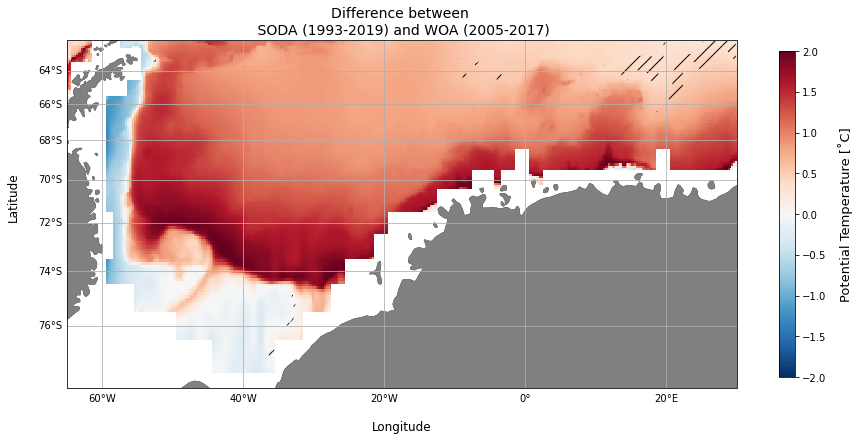

In [47]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(soda_woa0517_diff.lon, 
                   soda_woa0517_diff.lat, 
                   soda_woa0517_diff.where(land_mask.hfacc[0]), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-2, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

plt.contourf(soda_woa0517_diff.lon, 
             soda_woa0517_diff.lat,  
             soda_woa0517_diff.where(np.abs(soda_woa0517_diff) < woa0517_pt_error_new_grid.PT_error[0]).where(land_mask.hfacc[0]),
             transform=ccrs.PlateCarree(), colors='none', hatches=['//'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n SODA (1993-2019) and WOA (2005-2017)", fontsize=14);

# <span style='background:Pink'> <font color='Red'> Salinity </font>

### <span style='color:Brown'> Interpolating WOA (1981-2010) salt data onto ECCO's grid

In [13]:
regridder_slt = xe.Regridder(woa8110_slt, soda_slt, method='bilinear')

woa8110_slt_new_grid = regridder_slt(woa8110_slt)
woa8110_slt_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, lat: 169, lon: 381)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14
Data variables:
    san      (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 34.65 34.65 34.65
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (1981-2010) salt ERROR data onto ECCO's grid

In [14]:
regridder_slt_error = xe.Regridder(woa8110_slt_error.sse.fillna(0.), soda_slt, method='bilinear')

woa8110_slt_error_new_grid = regridder_slt_error(woa8110_slt_error)
woa8110_slt_error_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, lat: 169, lon: 381)
Coordinates:
  * time     (time) object -001-01-15 00:00:00
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14
Data variables:
    sse      (time, lat, lon) float32 0.0 0.0 0.0 ... 0.0003163 0.0003744
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom salinity `SODA - WOA` (1981-2010) </font>

In [28]:
#checking if nans
print(np.isnan(soda_slt.sum()))

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    time     object ...
Data variables:
    salt     bool False


In [15]:
soda_woa8110_slt_diff = soda_slt.salt - woa8110_slt_new_grid.isel(time=0).san
soda_woa8110_slt_diff

<xarray.DataArray (lat: 169, lon: 381)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [3.4722500e+01, 3.4722603e+01, 3.4722595e+01, ..., 1.9863129e-02,
        1.9989014e-02, 1.9969940e-02],
       [3.4722519e+01, 3.4722622e+01, 3.4721676e+01, ..., 1.9641876e-02,
        1.9721985e-02, 1.9645691e-02],
       [3.4722359e+01, 3.4721851e+01, 3.4721813e+01, ..., 1.9390106e-02,
        1.9313812e-02, 1.9035339e-02]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14

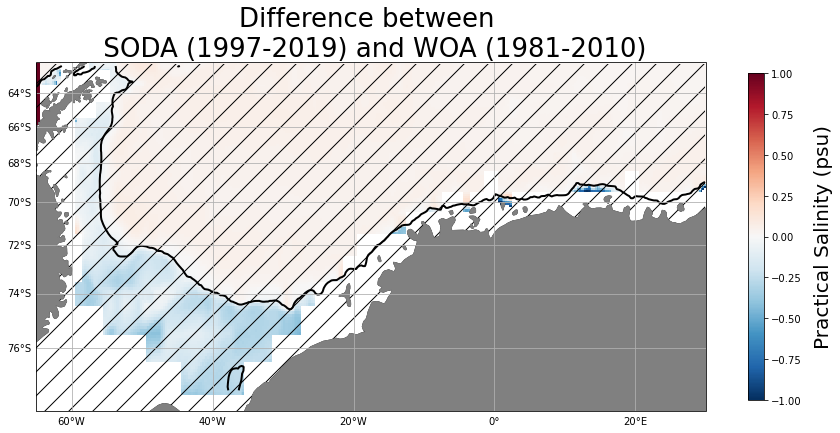

In [17]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))
#1000m isobath
ax.contour(lon, lat, depth, levels=[1000], colors='k', linewidths=2, transform=ccrs.PlateCarree())

im = ax.pcolormesh(soda_woa8110_slt_diff.lon, 
                   soda_woa8110_slt_diff.lat, 
                   soda_woa8110_slt_diff.where(land_mask.hfacc[0]), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-1, vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity (psu)", labelpad=12, fontsize=20)

plt.contourf(soda_woa8110_slt_diff.lon, 
             soda_woa8110_slt_diff.lat, 
             soda_woa8110_slt_diff.where(np.abs(soda_woa8110_slt_diff) < woa8110_slt_error_new_grid.sse[0]).where(land_mask.hfacc[0]).fillna(0.),
             transform=ccrs.PlateCarree(), colors='none', hatches=['/'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n SODA (1997-2019) and WOA (1981-2010)", fontsize=26)
plt.savefig('bot-salt-sodaWoa8110-1kmisobath.pdf');

### <span style='color:Brown'> Interpolating WOA (2005-2017) salt data onto SODA's grid

In [54]:
regridder_0517_slt = xe.Regridder(woa0517_slt, soda_slt, method='bilinear')

woa0517_slt_new_grid = regridder_0517_slt(woa0517_slt)
woa0517_slt_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, lat: 169, lon: 381)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14
Data variables:
    san      (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 34.65 34.65 34.65
Attributes:
    regrid_method:  bilinear

### <span style='color:Brown'> Interpolating WOA (2005-2017) salt ERROR data onto ECCO's grid

In [55]:
regridder_0517_slt_error = xe.Regridder(woa0517_slt_error, soda_slt, method='bilinear')

woa0517_slt_error_new_grid = regridder_0517_slt_error(woa0517_slt_error)
woa0517_slt_error_new_grid

<xarray.Dataset>
Dimensions:  (time: 1, lat: 169, lon: 381)
Coordinates:
  * time     (time) object -001-01-15 00:00:00
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14
Data variables:
    sse      (time, lat, lon) float32 0.0 0.0 0.0 ... nan 0.0002093 0.0001795
Attributes:
    regrid_method:  bilinear

## <span style='background:Yellow'> <font color='Red'> Bottom salinity `ECCO - WOA` (2005-2017) </font>

In [57]:
soda_woa0517_slt_diff = soda_slt.salt - woa0517_slt_new_grid.isel(time=0).san
soda_woa0517_slt_diff

<xarray.DataArray (lat: 169, lon: 381)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [3.4722500e+01, 3.4722603e+01, 3.4722595e+01, ..., 2.0133972e-02,
        2.0252228e-02, 2.0187378e-02],
       [3.4722519e+01, 3.4722622e+01, 3.4721676e+01, ..., 1.9924164e-02,
        1.9996643e-02, 1.9870758e-02],
       [3.4722359e+01, 3.4721851e+01, 3.4721813e+01, ..., 1.9680023e-02,
        1.9596100e-02, 1.9268036e-02]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -65.12 -64.88 -64.62 -64.38 ... 29.38 29.62 29.88
  * lat      (lat) float64 -80.02 -79.92 -79.81 -79.7 ... -62.37 -62.25 -62.14

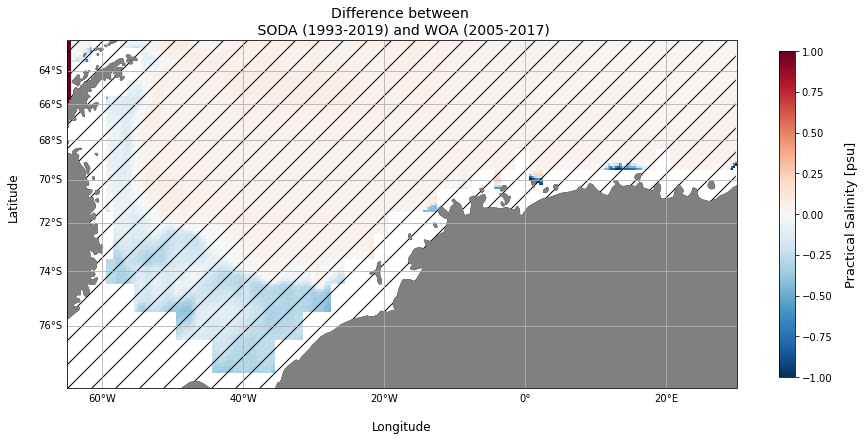

In [59]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(ecco_woa0517_slt_diff.lon, 
                   ecco_woa0517_slt_diff.lat, 
                   ecco_woa0517_slt_diff.where(land_mask.hfacc[0]), 
                   transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-1, vmax=1)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity [psu]", labelpad=12, fontsize=13)

plt.contourf(ecco_woa0517_slt_diff.lon, 
             ecco_woa0517_slt_diff.lat, 
             ecco_woa0517_slt_diff.where(np.abs(ecco_woa0517_slt_diff) < woa0517_slt_error_new_grid.sse[0]).where(land_mask.hfacc[0]).fillna(0.),
             transform=ccrs.PlateCarree(), colors='none', hatches=['/'])

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title("Difference between \n SODA (1993-2019) and WOA (2005-2017)", fontsize=14);